In [1]:
# imports
from utils import *

In [2]:
# read the configuration file and initialize random generators
cfg = read_config('configfiles/config_seed1.yaml')
initalize_random_generators(cfg)

(1370, 8427, 4069)

In [3]:
# load dataset 
allData = load_data(cfg['dataset']) #RT: added frac to speed-up trials and debugging

In [4]:
# process dataset (separate features & classes, split in train and test, reduce train size if needed)
X_cv, X_test, y_cv, y_test = data_prep(allData, cfg['features'], cfg['target'],
                                       randomState=cfg['dprep_seed'], 
                                       testSize=cfg['frac_tst'], 
                                       trainSize=cfg['train_size'])

In [5]:
# create folds using smoter (created beforehand to speed-up computation)
smoter = SMOTE(random_state=cfg['smote_seed'], sampling_strategy='auto', 
               k_neighbors = cfg['smote_kneighbors'], n_jobs = -1)
folds = create_folds_with_SMOTE(X_cv, y_cv, n_splits=cfg['n-folds'], smoter=None)

In [ ]:
# find best parameters for each algorithm via cross-validation
# run for 10 different starting seeds
for i in range(10):
    i += 1
    cfg = read_config('configfiles/config_seed{}.yaml'.format(i))
    initalize_random_generators(cfg)
    # find best parameters for each algorithm via cross-validation
    results = cv_model_selection(folds, cfg, i)
    # save results
    results.to_pickle('cv_results/cv_results_seed{}'.format(i))


In [6]:
# select best params combination for each algorithm
best_models, performance_distr = best_model_selection(cfg, 10)

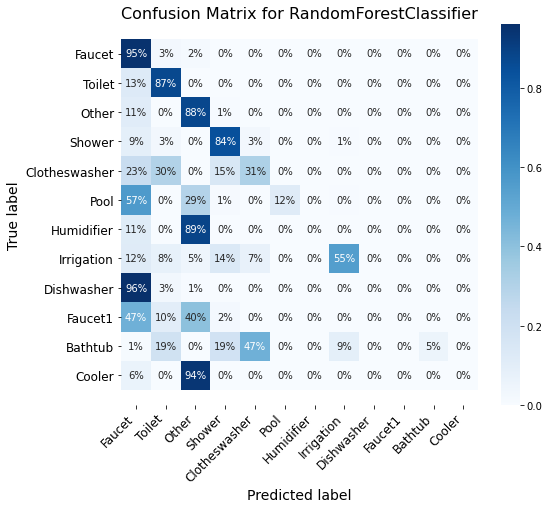

In [7]:
# store all test results for best models and plot confusion matrices
all_tst_preds = pd.DataFrame(columns = best_models['algorithm'])
for ix, row in best_models.iterrows():
    tst_preds, _ = single_model_cv_and_test(folds,row['algorithm'],row['params'],X_test,y_test)    
    _, ax = get_confusion_matrix(y_test, tst_preds, plot=True)
    ax.set_title('Confusion Matrix for '+ row['algorithm'], fontsize=16)
    all_tst_preds[row['algorithm']]=tst_preds


In [ ]:
# confusion matrix of majority vote ensemble
ens_preds = all_tst_preds.max(axis=1)
_, ax = get_confusion_matrix(y_test, ens_preds, plot=True)
ax.set_title('Confusion Matrix for Ensemble ', fontsize=16);

In [ ]:
# f1 scores
from sklearn.metrics import f1_score

# store all test results for best models and plot confusion matrices
for algorithm in all_tst_preds.columns:
    print(f"{algorithm}\ttest f1_score={f1_score(y_test, all_tst_preds[algorithm], average='micro'):.3f}".expandtabs(30))
    
print(f"{'Ensemble'}\ttest f1_score={f1_score(y_test, ens_preds, average='micro'):.3f}".expandtabs(30))
